In [2]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import json
import os
from sklearn.decomposition import PCA

# ---------------------------
# 1. Load data
# ---------------------------

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

# vit logits: (118 stimuli × 1000 classes)
vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']

# neural responses: (stimuli × neurons) → take transpose
R = np.load(NEURAL_PATH)   # (neurons × 118)
areas = np.load(AREAS_PATH, allow_pickle=True)

n_neurons, n_stim = R.shape
print("Loaded:", R.shape, "neurons × stimuli")

# ---------------------------
# 2. Get ImageNet class names
# ---------------------------

IMAGENET_CLASSFILE = "imagenet_class_index.json"

if not os.path.exists(IMAGENET_CLASSFILE):
    import urllib.request
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    urllib.request.urlretrieve(url, "imagenet_classes.txt")
    with open("imagenet_classes.txt", "r") as f:
        imagenet_classes = [line.strip() for line in f.readlines()]
else:
    with open(IMAGENET_CLASSFILE, "r") as f:
        imagenet_json = json.load(f)
    imagenet_classes = [imagenet_json[str(i)][1] for i in range(1000)]

print("Loaded ImageNet class names:", len(imagenet_classes), "classes")

# ---------------------------
# 3. Compute ViT PC1 semantic axis
# ---------------------------

pca_vit = PCA(n_components=1)
vit_pc1 = pca_vit.fit_transform(vit)[:, 0]

# normalize
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# sort stimuli by semantic axis
order_stimuli = np.argsort(v)

# ---------------------------
# 4. Compute neuron correlations with semantic axis
# ---------------------------

R_center = R - R.mean(axis=1, keepdims=True)
R_std = R.std(axis=1, keepdims=True) + 1e-8
corr = (R_center @ v) / (R_std[:, 0] * (len(v)-1))

# sort neurons
order_neurons = np.argsort(-corr)
R_sorted_neurons = R[order_neurons]

# also sort correlations and areas
corr_sorted = corr[order_neurons]
areas_sorted = areas[order_neurons]

# ---------------------------
# 5. Extract ViT top classes
# ---------------------------

vit_top_idx = np.argmax(vit, axis=1)  # top-1 class index per stimulus
vit_top_classes = [imagenet_classes[i] for i in vit_top_idx]

# ---------------------------
# 6. Create GIF showing neural activity along semantic axis
# ---------------------------

os.makedirs("frames", exist_ok=True)
frame_paths = []

print("Generating GIF frames...")

for frame_num, stim_idx in enumerate(order_stimuli):
    
    plt.figure(figsize=(12, 4))
    plt.plot(R_sorted_neurons[:, stim_idx], linewidth=0.5)
    plt.ylim(0, R_sorted_neurons.max())
    plt.title(
        f"Stimulus {stim_idx}  |  Semantic rank {frame_num}/{n_stim}  |  ViT top class: {vit_top_classes[stim_idx]}"
    )
    plt.xlabel("Neuron index (sorted by semantic tuning)")
    plt.ylabel("Event probability")
    
    frame_file = f"frames/frame_{frame_num:03d}.png"
    plt.savefig(frame_file, dpi=120, bbox_inches='tight')
    plt.close()
    
    frame_paths.append(frame_file)

# Write GIF
images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neural_semantic_geodesic.gif", images, fps=6)

print("GIF saved as neural_semantic_geodesic.gif")


Loaded: (39209, 118) neurons × stimuli
Loaded ImageNet class names: 1000 classes
Generating GIF frames...


/tmp/ipykernel_567862/604532367.py:108: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


GIF saved as neural_semantic_geodesic.gif


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
import urllib.request
import json

# ---------------------------
# LOAD DATA
# ---------------------------
VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']        # (118,1000)
R = np.load(NEURAL_PATH)[:500]                                      # (39209,118)
areas = np.load(AREAS_PATH, allow_pickle=True)

n_neurons, n_stim = R.shape

# ---------------------------
# LOAD IMAGENET CLASS NAMES
# ---------------------------
if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# ---------------------------
# COMPUTE VIT PC1 (semantic axis)
# ---------------------------
pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]

# normalize
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# sort stimuli along semantic axis
order_stim = np.argsort(v)
vit_sorted = vit[order_stim]

# top-1 classes
vit_top_idx = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])

# sorted classes for x-axis labels
class_labels_sorted = vit_top_classes[order_stim]

# ---------------------------
# GIF SETUP
# ---------------------------
os.makedirs("frames_neuron", exist_ok=True)
frame_paths = []

print("Generating neuron-centric GIF frames...")

# MAKE SHORT HUMAN-READABLE X-AXIS TICKS
def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]

short_labels = [shorten(lbl) for lbl in class_labels_sorted]

# ---------------------------
# LOOP THROUGH NEURONS
# ---------------------------
# global y-axis limits
ymin = R.min()
ymax = R.max()

for neuron_idx in range(n_neurons):

    y = R[neuron_idx, order_stim]

    plt.figure(figsize=(12,4))
    plt.plot(y, linewidth=1)
    plt.ylim(ymin, ymax)

    plt.title(
        f"Neuron {neuron_idx} | Area: {areas[neuron_idx]}\n"
        f"Semantic tuning curve across stimuli sorted by ViT PC1"
    )
    plt.ylabel("Event probability")
    plt.xlabel("Stimuli sorted by semantic axis")

    xticks = np.linspace(0, n_stim-1, 12, dtype=int)
    plt.xticks(xticks, [short_labels[i] for i in xticks], rotation=45)

    frame_file = f"frames_neuron/frame_{neuron_idx:05d}.png"
    plt.savefig(frame_file, dpi=120)   # FIXED: removed 'bbox_inches=tight'
    plt.close()

    frame_paths.append(frame_file)

    if neuron_idx % 500 == 0:
        print(f"Rendered {neuron_idx}/{n_neurons} neurons...")


# ---------------------------
# MAKE GIF
# ---------------------------
images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neuron_semantic_tuning.gif", images, fps=10)

print("Saved GIF: neuron_semantic_tuning.gif")


Generating neuron-centric GIF frames...
Rendered 0/500 neurons...


/tmp/ipykernel_567862/990963303.py:106: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


Saved GIF: neuron_semantic_tuning.gif


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
import urllib.request
import json

# ---------------------------
# LOAD DATA
# ---------------------------
VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH = '/home/maria/ProjectionSort/data/brain_area.npy'

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # (118,1000)
R_full = np.load(NEURAL_PATH)                                  # (stimuli × neurons) or (neurons × stimuli)
R_full = R_full                                            # ensure (neurons × stimuli)

areas = np.load(AREAS_PATH, allow_pickle=True)

n_total, n_stim = R_full.shape

# ---------------------------
# SAMPLE 1000 NEURONS
# ---------------------------
np.random.seed(0)
chosen = np.random.choice(n_total, size=100, replace=False)

R = R_full[chosen]
areas_subset = areas[chosen]

n_neurons = R.shape[0]

print("Using 1000 randomly sampled neurons of shape:", R.shape)

# ---------------------------
# LOAD IMAGENET CLASS NAMES
# ---------------------------
if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# ---------------------------
# COMPUTE VIT PC1 (semantic axis)
# ---------------------------
pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]

# normalize
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# sort stimuli along semantic axis
order_stim = np.argsort(v)

# top-1 classes
vit_top_idx = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])

# labels sorted by semantic axis
class_labels_sorted = vit_top_classes[order_stim]

# ---------------------------
# HELPER: shorten class labels
# ---------------------------
def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]

short_labels = np.array([shorten(lbl) for lbl in class_labels_sorted])

# ---------------------------
# GIF SETUP
# ---------------------------
os.makedirs("frames_neuron", exist_ok=True)
frame_paths = []

ymin = R.min()
ymax = R.max()

print("Generating GIF frames...")

# ---------------------------
# LOOP THROUGH 1000 NEURONS
# ---------------------------
for idx, neuron_idx in enumerate(range(n_neurons)):
    
    y = R[neuron_idx, order_stim]      # semantic sorted timeseries

    plt.figure(figsize=(12,4))
    plt.plot(y, linewidth=1)
    plt.ylim(ymin, ymax)

    plt.title(
        f"Neuron {chosen[neuron_idx]} | Area: {areas_subset[neuron_idx]}\n"
        f"Semantic tuning curve (ViT PC1 sorted stimuli)"
    )
    plt.ylabel("Event probability")
    plt.xlabel("Semantic axis (ViT PC1)")

    xticks = np.linspace(0, n_stim-1, 10, dtype=int)
    plt.xticks(xticks, short_labels[xticks], rotation=45)

    frame_file = f"frames_neuron/frame_{idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if idx % 200 == 0:
        print(f"{idx}/{n_neurons} frames completed")

# ---------------------------
# MAKE SLOW GIF
# ---------------------------
images = [imageio.imread(fp) for fp in frame_paths]

# fps=2 makes it 5× slower than before
imageio.mimsave("neuron_semantic_tuning_slow.gif", images, fps=0.5)

print("Saved GIF: neuron_semantic_tuning_slow.gif")


Using 1000 randomly sampled neurons of shape: (100, 118)
Generating GIF frames...
0/100 frames completed


/tmp/ipykernel_697054/3904997699.py:120: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


Saved GIF: neuron_semantic_tuning_slow.gif


In [10]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'
IMAGE_DIR   = '/home/maria/ProjectionSort/data/images/images'   # adjust if needed

N_SAMPLE_NEURONS = 100
FPS = 2   # slow, readable GIF
ZOOM = 0.22  # image thumbnail scaling



# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # (118, 1000)
R_full = np.load(NEURAL_PATH)                             # (39209, 118)
areas_full = np.load(AREAS_PATH, allow_pickle=True)


R_full = np.load(NEURAL_PATH)

# --- Fix orientation (the key bug) ---
if R_full.shape[0] == 118:
    print("R_full appears to be (stimuli × neurons); transposing...")
    R_full = R_full.T
elif R_full.shape[1] == 118:
    print("R_full is already (neurons × stimuli)")
else:
    print("Unexpected shape:", R_full.shape)
n_total, n_stim = R_full.shape

# ============================================================
# SAMPLE NEURONS
# ============================================================

print(f"Sampling {N_SAMPLE_NEURONS} neurons out of {n_total}...")

np.random.seed(0)
chosen = np.random.choice(n_total, size=N_SAMPLE_NEURONS, replace=False)

R = R_full[chosen]                 # (1000, 118)
areas = areas_full[chosen]         # area labels for those neurons
n_neurons = R.shape[0]

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# ============================================================
# COMPUTE SEMANTIC AXIS USING ViT PC1
# ============================================================

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]

# normalize
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# sort stimuli along semantic axis
order_stim = np.argsort(v)

# top-1 class label for each stimulus
vit_top_idx     = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])

# extract class names in sorted semantic order
class_labels_sorted = vit_top_classes[order_stim]

def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]

short_labels = np.array([shorten(lbl) for lbl in class_labels_sorted])

# ============================================================
# GIF OUTPUT FOLDER
# ============================================================

os.makedirs("frames_neuron", exist_ok=True)
frame_paths = []

# global y-axis range for consistency
ymin = R.min()
ymax = R.max()

print("Generating frames with embedded images...")

# ============================================================
# MAIN LOOP — ONE NEURON PER FRAME
# ============================================================

for idx, neuron_idx in enumerate(range(n_neurons)):

    y = R[neuron_idx, order_stim]   # sorted timeseries

    plt.figure(figsize=(12, 4))
    plt.plot(y, linewidth=1)
    plt.ylim(ymin, ymax)

    plt.title(
        f"Neuron {chosen[neuron_idx]} | Area: {areas[neuron_idx]}\n"
        "Semantic tuning curve (ViT PC1 sorted stimuli)"
    )
    plt.ylabel("Event probability")
    plt.xlabel("Semantic axis")

    xticks = np.linspace(0, n_stim-1, 10, dtype=int)
    plt.xticks(xticks, short_labels[xticks], rotation=45)

    # --------------------------------------------------------
    # TOP 3 MOST ACTIVATING STIMULI — place images in the plot
    # --------------------------------------------------------
    top3_local = np.argsort(y)[-3:]              # positions along semantic axis
    top3_global = order_stim[top3_local]         # original stimulus indices

    for local_x, global_idx in zip(top3_local, top3_global):

        img_path = f"{IMAGE_DIR}/scene_{global_idx:03d}.png"

        if os.path.exists(img_path):
            img = Image.open(img_path)
            im = OffsetImage(img, zoom=ZOOM)
            ab = AnnotationBbox(
                im,
                (local_x, ymax * 1.10),   # place slightly above curve
                frameon=False
            )
            plt.gca().add_artist(ab)
        else:
            print(f"WARNING: Image not found: {img_path}")

    # --------------------------------------------------------
    # SAVE FRAME
    # --------------------------------------------------------
    frame_file = f"frames_neuron/frame_{idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if idx % 100 == 0:
        print(f"Rendered {idx}/{n_neurons} neurons...")

# ============================================================
# GENERATE GIF
# ============================================================

print("Creating GIF...")

images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neuron_semantic_tuning_with_images.gif", images, fps=FPS)

print("GIF saved as neuron_semantic_tuning_with_images.gif")


Loading data...
R_full is already (neurons × stimuli)
Sampling 100 neurons out of 39209...
Generating frames with embedded images...
Rendered 0/100 neurons...
Creating GIF...


/tmp/ipykernel_697054/4281726875.py:174: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


GIF saved as neuron_semantic_tuning_with_images.gif


Local top3 positions: [ 19  80 117]
Global stimulus IDs: [94 58 29]
Checking file: /home/maria/ProjectionSort/data/images/images/scene_094.png exists = True
Loaded image size: (96, 96)
Checking file: /home/maria/ProjectionSort/data/images/images/scene_058.png exists = True
Loaded image size: (96, 96)
Checking file: /home/maria/ProjectionSort/data/images/images/scene_029.png exists = True
Loaded image size: (96, 96)


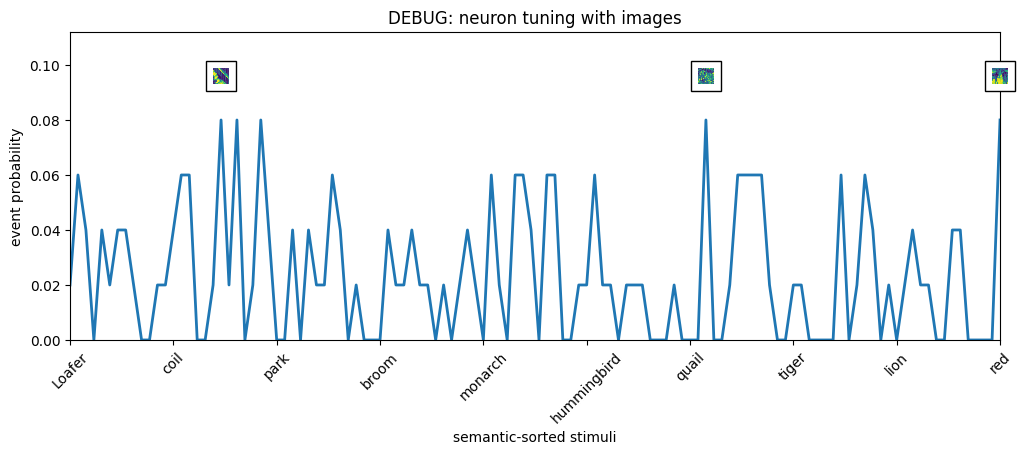

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import os

# --- pick one neuron ---
neuron_idx = 0

# --- get its semantic tuning curve ---
y = R[neuron_idx, order_stim]

plt.figure(figsize=(12,4))
plt.plot(y, linewidth=2)
plt.title("DEBUG: neuron tuning with images")
plt.xlabel("semantic-sorted stimuli")
plt.ylabel("event probability")

# EXPAND y-limits to make room ABOVE the curve
plt.ylim(y.min(), y.max() * 1.4)

# ensure x-limits
plt.xlim(0, len(order_stim)-1)

# tick labels
xticks = np.linspace(0, len(order_stim)-1, 10, dtype=int)
plt.xticks(xticks, short_labels[xticks], rotation=45)

# --- top-3 stimuli ---
top3_local = np.argsort(y)[-3:]
top3_global = order_stim[top3_local]

print("Local top3 positions:", top3_local)
print("Global stimulus IDs:", top3_global)

# --- try to plot each image ---
for local_x, global_idx in zip(top3_local, top3_global):

    img_path = f"{IMAGE_DIR}/scene_{global_idx:03d}.png"
    print("Checking file:", img_path, "exists =", os.path.exists(img_path))

    if not os.path.exists(img_path):
        continue

    # load it
    img = Image.open(img_path)

    # DEBUG print image size
    print("Loaded image size:", img.size)

    # embed into plot
    im = OffsetImage(img, zoom=0.12)

    ab = AnnotationBbox(
        im,
        (local_x, y.max() * 1.2),
        xycoords="data",
        frameon=True,        # <- ENABLE FRAME so you can SEE the box!
        pad=0.5
    )
    plt.gca().add_artist(ab)

plt.show()


In [17]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from PIL import Image
import urllib.request

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH   = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH  = '/home/maria/ProjectionSort/data/brain_area.npy'

IMAGE_DIR   = '/home/maria/ProjectionSort/data/images/images'  # <-- your correct folder

N_SAMPLE_NEURONS = 100
FPS  = 0.75     # slow GIF
ZOOM = 0.18  # image thumbnail scale
ZOOM = 0.45

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']  # (118, 1000)
R_full = np.load(NEURAL_PATH)                                  # maybe (39209,118)
areas_full = np.load(AREAS_PATH, allow_pickle=True)

# Fix orientation: ensure shape = (neurons × stimuli)
if R_full.shape[0] == 118:
    print("Transposing neural matrix (it was stimuli × neurons)...")
    R_full = R_full.T
elif R_full.shape[1] == 118:
    print("Neural matrix is (neurons × stimuli)")
else:
    print("ERROR: unexpected shape", R_full.shape)

n_total, n_stim = R_full.shape
print(f"Neural matrix: {n_total} neurons × {n_stim} stimuli")

# ============================================================
# SAMPLE NEURONS
# ============================================================

np.random.seed(0)
chosen = np.random.choice(n_total, size=N_SAMPLE_NEURONS, replace=False)
R = R_full[chosen]
areas = areas_full[chosen]
n_neurons = R.shape[0]

print(f"Using {n_neurons} sampled neurons")

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# ============================================================
# COMPUTE SEMANTIC AXIS USING ViT PC1
# ============================================================

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]

# normalize PC1
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# stimuli sorted along semantic axis
order_stim = np.argsort(v)

# ViT top-1 classes
vit_top_idx = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])

# class labels in sorted semantic order
class_labels_sorted = vit_top_classes[order_stim]

def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]

short_labels = np.array([shorten(lbl) for lbl in class_labels_sorted])

# ============================================================
# GIF OUTPUT FOLDER
# ============================================================

os.makedirs("frames_neuron", exist_ok=True)
frame_paths = []

# consistent y-limits with headroom for images
ymin = R.min()
ymax = R.max()
YTOP = ymax * 1.30    # extend vertical axis so images fit

# ============================================================
# MAIN LOOP — ONE NEURON PER FRAME
# ============================================================

print("Generating frames with embedded images...")

for idx, neuron_idx in enumerate(range(n_neurons)):

    y = R[neuron_idx, order_stim]  # semantic-sorted timeseries

    plt.figure(figsize=(12, 5))
    plt.plot(y, linewidth=1)
    plt.ylim(ymin, YTOP)       # <-- increased vertical room
    plt.xlim(0, n_stim-1)

    plt.title(
        f"Neuron {chosen[neuron_idx]} | Area: {areas[neuron_idx]}\n"
        "Semantic tuning curve (ViT PC1 sorted stimuli)"
    )
    plt.ylabel("Event probability")
    plt.xlabel("Semantic axis (sorted stimuli)")

    xticks = np.linspace(0, n_stim-1, 10, dtype=int)
    plt.xticks(xticks, short_labels[xticks], rotation=45)

    # --------------------------------------------------------
    # TOP 3 MOST ACTIVATING STIMULI — embed images in the plot
    # --------------------------------------------------------
    top3_local  = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base_path = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        img_path = None

        # support PNG or JPG
        if os.path.exists(base_path + ".png"):
            img_path = base_path + ".png"
        elif os.path.exists(base_path + ".jpg"):
            img_path = base_path + ".jpg"

        if img_path is None:
            print("WARNING missing image:", base_path)
            continue

        img = Image.open(img_path)
        im  = OffsetImage(img, zoom=ZOOM)

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.15),   # appear above the peak
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # --------------------------------------------------------
    # SAVE FRAME
    # --------------------------------------------------------
    frame_file = f"frames_neuron/frame_{idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if idx % 20 == 0:
        print(f"Rendered {idx}/{n_neurons} neurons...")

# ============================================================
# GENERATE GIF
# ============================================================

print("Creating GIF...")

images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neuron_semantic_tuning_with_images.gif", images, fps=FPS)

print("GIF saved as neuron_semantic_tuning_with_images.gif")


Loading data...
Neural matrix is (neurons × stimuli)
Neural matrix: 39209 neurons × 118 stimuli
Using 100 sampled neurons
Generating frames with embedded images...
Rendered 0/100 neurons...
Rendered 20/100 neurons...
Rendered 40/100 neurons...
Rendered 60/100 neurons...
Rendered 80/100 neurons...
Creating GIF...


/tmp/ipykernel_697054/466881925.py:184: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


GIF saved as neuron_semantic_tuning_with_images.gif


In [19]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import urllib.request

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH   = '/home/maria/ProjectionSort/data/brain_area.npy'
IMAGE_DIR    = '/home/maria/ProjectionSort/data/images/images'  # contains scene_000.png ...

N_SAMPLE_NEURONS = 100
FPS  = 0.75
ZOOM = 0.6  # 2.5× larger images than before

# ============================================================
# DEFINE SUNSET BLISS COLORMAP
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),   # light pink
    (0.92, 0.49, 0.68),   # pink-purple
    (0.65, 0.34, 0.63),   # purple
    (0.34, 0.28, 0.55),   # indigo
    (0.19, 0.22, 0.44),   # deep blue
    (0.99, 0.66, 0.36),   # orange
    (1.00, 0.80, 0.40)    # golden
]

sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']      # (118, 1000)
R_full = np.load(NEURAL_PATH)                                     # maybe (118, neurons)
areas_full = np.load(AREAS_PATH, allow_pickle=True)

# --- Ensure orientation = (neurons × stimuli) ---
if R_full.shape[0] == 118:
    print("Matrix is (stim × neurons) → transposing")
    R_full = R_full.T
elif R_full.shape[1] == 118:
    print("Matrix already (neurons × stim)")
else:
    raise ValueError("Unexpected neural data shape: " + str(R_full.shape))

n_total, n_stim = R_full.shape

# ============================================================
# SAMPLE NEURONS
# ============================================================

np.random.seed(0)
chosen = np.random.choice(n_total, size=N_SAMPLE_NEURONS, replace=False)

R = R_full[chosen]
areas = areas_full[chosen]
n_neurons = R.shape[0]

print(f"Using {n_neurons} sampled neurons")

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# ============================================================
# COMPUTE SEMANTIC AXIS USING ViT PC1
# ============================================================

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]

# normalize
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

# sorted stimuli along semantic axis
order_stim = np.argsort(v)

# ViT top class per stimulus
vit_top_idx = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])

class_labels_sorted = vit_top_classes[order_stim]

def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]

short_labels = np.array([shorten(lbl) for lbl in class_labels_sorted])

# ============================================================
# GIF SETUP
# ============================================================

os.makedirs("frames_neuron", exist_ok=True)
frame_paths = []

ymin = R.min()
ymax = R.max()
YTOP = ymax * 1.6   # extra room for image thumbnails

# ============================================================
# MAIN LOOP — ONE NEURON PER FRAME
# ============================================================

print("Creating frames with embedded images...")

for idx, neuron_idx in enumerate(range(n_neurons)):

    y = R[neuron_idx, order_stim]  # tuning curve

    plt.figure(figsize=(12, 6))
    plt.ylim(ymin, YTOP)
    plt.xlim(0, n_stim-1)

    # Sunset Bliss point gradient
    colors = sunset_bliss(np.linspace(0, 1, n_stim))
    plt.scatter(
        np.arange(n_stim), y,
        c=colors, s=24, alpha=0.9
    )

    # Sunset Bliss smooth line
    plt.plot(
        np.arange(n_stim), y,
        color=sunset_bliss(0.75),
        linewidth=1.3
    )

    plt.title(
        f"Neuron {chosen[neuron_idx]} | Area: {areas[neuron_idx]}\n"
        "Semantic tuning curve (ViT PC1 sorted stimuli)",
    )
    plt.xlabel("Semantic axis (sorted by ViT PC1)")
    plt.ylabel("Event probability")
    plt.grid(alpha=0.15, color=sunset_bliss(0.3))

    xticks = np.linspace(0, n_stim-1, 10, dtype=int)
    plt.xticks(xticks, short_labels[xticks], rotation=45)

    # --------------------------------------------------------
    # TOP-3 MOST ACTIVATING IMAGES
    # --------------------------------------------------------
    top3_local  = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base_path = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        img_path = None

        if os.path.exists(base_path + ".png"):
            img_path = base_path + ".png"
        elif os.path.exists(base_path + ".jpg"):
            img_path = base_path + ".jpg"
        else:
            print("Missing image:", base_path)
            continue

        img = Image.open(img_path)
        im  = OffsetImage(img, zoom=ZOOM)

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.3),   # larger images, higher placement
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # --------------------------------------------------------
    # SAVE FRAME
    # --------------------------------------------------------
    frame_file = f"frames_neuron/frame_{idx:05d}.png"
    plt.savefig(frame_file, dpi=120)
    plt.close()

    frame_paths.append(frame_file)

    if idx % 20 == 0:
        print(f"{idx}/{n_neurons} frames complete")

# ============================================================
# GENERATE GIF
# ============================================================

print("Generating GIF...")

images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neuron_semantic_tuning_with_images.gif", images, fps=FPS)

print("GIF saved as neuron_semantic_tuning_with_images.gif")


Loading data...
Matrix already (neurons × stim)
Using 100 sampled neurons
Creating frames with embedded images...
0/100 frames complete
20/100 frames complete
40/100 frames complete
60/100 frames complete
80/100 frames complete
Generating GIF...


/tmp/ipykernel_697054/1746876579.py:209: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


GIF saved as neuron_semantic_tuning_with_images.gif


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os
from sklearn.decomposition import PCA
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import urllib.request

# ============================================================
# CONFIGURATION
# ============================================================

VIT_PATH     = '/home/maria/ProjectionSort/data/google_vit-base-patch16-224_embeddings_logits.pkl'
NEURAL_PATH  = '/home/maria/ProjectionSort/data/hybrid_neural_responses_reduced.npy'
AREAS_PATH   = '/home/maria/ProjectionSort/data/brain_area.npy'
IMAGE_DIR    = '/home/maria/ProjectionSort/data/images/images'

N_SAMPLE_NEURONS = 500
FPS  = 0.75
ZOOM = 0.6    # larger embedded images

# ============================================================
# DEFINE SUNSET BLISS COLORMAP
# ============================================================

sunset_bliss_colors = [
    (0.99, 0.77, 0.80),   # light pink
    (0.92, 0.49, 0.68),   # pink-purple
    (0.65, 0.34, 0.63),   # purple
    (0.34, 0.28, 0.55),   # indigo
    (0.19, 0.22, 0.44),   # deep blue
    (0.99, 0.66, 0.36),   # orange
    (1.00, 0.80, 0.40)    # golden
]

sunset_bliss = LinearSegmentedColormap.from_list("sunset_bliss", sunset_bliss_colors)

# ============================================================
# LOAD DATA
# ============================================================

print("Loading data...")

vit = np.load(VIT_PATH, allow_pickle=True)['natural_scenes']
R_full = np.load(NEURAL_PATH)
areas_full = np.load(AREAS_PATH, allow_pickle=True)

# Ensure R_full is (neurons × stimuli)
if R_full.shape[0] == 118:
    print("Matrix is (stim × neurons) → transposing")
    R_full = R_full.T
elif R_full.shape[1] == 118:
    print("Matrix is already (neurons × stim)")
else:
    raise ValueError(f"Unexpected neural shape: {R_full.shape}")

n_total, n_stim = R_full.shape

# ============================================================
# SAMPLE NEURONS
# ============================================================

np.random.seed(0)
chosen = np.random.choice(n_total, size=N_SAMPLE_NEURONS, replace=False)

R = R_full[chosen]
areas = areas_full[chosen]
n_neurons = R.shape[0]

print(f"Using {n_neurons} sampled neurons")

# ============================================================
# LOAD IMAGENET CLASS NAMES
# ============================================================

if not os.path.exists("imagenet_classes.txt"):
    urllib.request.urlretrieve(
        "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt",
        "imagenet_classes.txt"
    )

with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [line.strip() for line in f.readlines()]

# ============================================================
# SEMANTIC AXIS (ViT PC1)
# ============================================================

pca = PCA(n_components=1)
vit_pc1 = pca.fit_transform(vit)[:, 0]
v = (vit_pc1 - vit_pc1.mean()) / vit_pc1.std()

order_stim = np.argsort(v)

vit_top_idx     = np.argmax(vit, axis=1)
vit_top_classes = np.array([imagenet_classes[i] for i in vit_top_idx])
class_labels_sorted = vit_top_classes[order_stim]

def shorten(label):
    return label.split(",")[0].split(" ")[0][:12]

short_labels = np.array([shorten(lbl) for lbl in class_labels_sorted])

# ============================================================
# GIF SETUP
# ============================================================

os.makedirs("frames_neuron", exist_ok=True)
frame_paths = []

ymin = R.min()
ymax = R.max()
YTOP = ymax * 1.6   # room for thumbnails

# ============================================================
# MAIN LOOP — ONE NEURON PER FRAME
# ============================================================

print("Generating frames with grayscale images...")

for idx, neuron_idx in enumerate(range(n_neurons)):

    y = R[neuron_idx, order_stim]

    plt.figure(figsize=(12, 6))
    plt.ylim(ymin, YTOP)
    plt.xlim(0, n_stim - 1)

    # Sunset Bliss scatter
    colors = sunset_bliss(np.linspace(0, 1, n_stim))
    plt.scatter(
        np.arange(n_stim), y, 
        c=colors, s=24, alpha=0.9
    )

    # Sunset Bliss line
    plt.plot(
        np.arange(n_stim), y,
        color=sunset_bliss(0.75),
        linewidth=1.3
    )

    plt.title(
        f"Neuron {chosen[neuron_idx]} | Area: {areas[neuron_idx]}\n"
        "Semantic tuning curve (ViT PC1 sorted stimuli)",
    )
    plt.xlabel("Semantic axis (sorted)")
    plt.ylabel("Event probability")
    plt.grid(alpha=0.15, color=sunset_bliss(0.3))

    xticks = np.linspace(0, n_stim - 1, 10, dtype=int)
    plt.xticks(xticks, short_labels[xticks], rotation=45)

    # --------------------------------------------------------
    # TOP-3 MOST ACTIVATING IMAGES (GRAYSCALE)
    # --------------------------------------------------------
    top3_local  = np.argsort(y)[-3:]
    top3_global = order_stim[top3_local]

    for local_x, global_idx in zip(top3_local, top3_global):

        base = f"{IMAGE_DIR}/scene_{global_idx:03d}"
        if os.path.exists(base + ".png"):
            img_path = base + ".png"
        elif os.path.exists(base + ".jpg"):
            img_path = base + ".jpg"
        else:
            print("Missing image:", base)
            continue

        # Load image in grayscale
        img = Image.open(img_path).convert("L")

        im = OffsetImage(img, zoom=ZOOM, cmap="gray")

        ab = AnnotationBbox(
            im,
            (local_x, ymax * 1.3),
            xycoords='data',
            frameon=False
        )
        plt.gca().add_artist(ab)

    # --------------------------------------------------------
    # SAVE FRAME
    # --------------------------------------------------------
    frame_path = f"frames_neuron/frame_{idx:05d}.png"
    plt.savefig(frame_path, dpi=120)
    plt.close()

    frame_paths.append(frame_path)

    if idx % 20 == 0:
        print(f"{idx}/{n_neurons} frames complete")

# ============================================================
# GENERATE GIF
# ============================================================

print("Generating GIF...")

images = [imageio.imread(fp) for fp in frame_paths]
imageio.mimsave("neuron_semantic_tuning_with_images_grayscale.gif", images, fps=FPS)

print("GIF saved as neuron_semantic_tuning_with_images_grayscale.gif")


Loading data...
Matrix is already (neurons × stim)
Using 500 sampled neurons
Generating frames with grayscale images...
0/500 frames complete
20/500 frames complete
40/500 frames complete
60/500 frames complete
80/500 frames complete
100/500 frames complete
120/500 frames complete
140/500 frames complete
160/500 frames complete
180/500 frames complete
200/500 frames complete
220/500 frames complete
240/500 frames complete
260/500 frames complete
280/500 frames complete
300/500 frames complete
320/500 frames complete
340/500 frames complete
360/500 frames complete
380/500 frames complete
400/500 frames complete
420/500 frames complete
440/500 frames complete
460/500 frames complete
480/500 frames complete
Generating GIF...


/tmp/ipykernel_697054/792207789.py:204: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images = [imageio.imread(fp) for fp in frame_paths]


GIF saved as neuron_semantic_tuning_with_images_grayscale.gif
